**Names of all group members:** Ramon Kaspar, Cyrill Stotz

In [109]:
# Exercise 1.
import numpy as np
np.random.seed(0)  # for reproducibility

# simulate explanatory variables x
m = 20000
n = 10000

vectors = []

for i in range(m+n):
    age = np.random.uniform(18, 80)
    income = np.random.uniform(1, 15)
    self_employed = np.random.choice([0, 1], p=[0.9, 0.1])
    vectors.append((age, income, self_employed))

vectors = np.array(vectors)

# a) calculate empirical means and standard deviations over training data
training_data = vectors[:m]
ages = training_data[:, 0]
incomes = training_data[:, 1]
employment_status = training_data[:, 2]

mean_age = np.mean(ages)
std_age = np.std(ages)
print("Age (mean, std):", mean_age, std_age)

mean_income = np.mean(incomes)
std_income = np.std(incomes)
print("Income (mean, std):", mean_income, std_income)

mean_employment_status = np.mean(employment_status)
std_employment_status = np.std(employment_status)
print("Employment status (mean, std):", mean_employment_status, std_employment_status)

# b) Can you come up with a few (2 or 3) additional features that may be relevant?
# (you don't have to implement those of course, just write down your answer in text)
# (1) Amount of the loan requested from the bank
# (2) Ratio from debt to income
# (3) Duration of employment

Age (mean, std): 48.93285648483437 17.933866426205466
Income (mean, std): 7.930161275593197 4.039030555277308
Employment status (mean, std): 0.1021 0.3027797714511325


In [110]:
# Exercise 2.
# Building the datasets:

sigmoid = lambda x: 1. / (1. + np.exp(-x))

# \xi is uniformly distributed on (0,1)
xi = np.random.uniform(0, 1, m + n)

# build the first dataset
def p1(x):
    return sigmoid(13.3 - 0.33 * x[0] + 3.5 * x[1] - 3 * x[2])

y1 = np.zeros(m+n)
for i in range(m+n):
    if xi[i] <= p1(vectors[i]):
        y1[i] = 1

dataset1 = np.column_stack((vectors, y1))

# build the second dataset
def p2(x):
    age_threshold = 1 * (x[0] < 25) + 1 * (x[0] > 75)
    return sigmoid(5 - 10 * age_threshold + 1.1 * x[1] - x[2])

y2 = np.zeros(m+n)
for i in range(m+n):
    if xi[i] <= p2(vectors[i]):
        y2[i] = 1

dataset2 = np.column_stack((vectors, y2))
        
assert dataset1.shape == (m+n, 4) and dataset2.shape == (m+n, 4)

# Print some statistics about the datasets
print("Dataset1: Number of 'good' borrowers:", np.sum(dataset1[:, 3]))
print("Dataset2: Number of 'good' borrowers:", np.sum(dataset2[:, 3]))

Dataset1: Number of 'good' borrowers: 28455.0
Dataset2: Number of 'good' borrowers: 28464.0


In [111]:
# Exercise 2. a)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
# "model = LogisticRegression().fit(X_data, Y_data)" fits a model
# "pred_X = model.predict_proba(X)" evaluates the model
# (note that it outputs both P(Y=0|X) and P(Y=1|X))
# "log_loss(Y, pred_X)" evaluates the negative conditional log likelihood (also called cross-entropy loss)

# Create the datasets (split into traind and test, split X and y)
X_train1 = dataset1[:m, :3]
y_train1 = dataset1[:m, 3]
X_test1 = dataset1[m:, :3]
y_test1 = dataset1[m:, 3]

X_train2 = dataset2[:m, :3]
y_train2 = dataset2[:m, 3]
X_test2 = dataset2[m:, :3]
y_test2 = dataset2[m:, 3]

# Fit the models on both datasets
model1 = LogisticRegression().fit(X_train1, y_train1)
model2 = LogisticRegression().fit(X_train2, y_train2)

# Calculate cross-entropy loss on both datasets for train and test
pred_train1 = model1.predict_proba(X_train1)
pred_test1 = model1.predict_proba(X_test1)
loss_train1 = log_loss(y_train1, pred_train1)
loss_test1 = log_loss(y_test1, pred_test1)
print("Train Loss LogReg (Dataset1): ", loss_train1)
print("Test Loss LogReg (Dataset1): ", loss_test1)

pred_train2 = model2.predict_proba(X_train2)
pred_test2 = model2.predict_proba(X_test2)
loss_train2 = log_loss(y_train2, pred_train2)
loss_test2 = log_loss(y_test2, pred_test2)
print("Train Loss LogReg (Dataset2): ", loss_train2)
print("Test Loss LogReg (Dataset2): ", loss_test2)

Train Loss LogReg (Dataset1):  0.03497571542907223
Test Loss LogReg (Dataset1):  0.03636542246757349
Train Loss LogReg (Dataset2):  0.15420197382698547
Test Loss LogReg (Dataset2):  0.15261432694046353


In [112]:
# Exercise 2. b)
# Calculate normalized data
# We use the empirical standard deviations from task 1
X_train1_normalized = X_train1 / [std_age, std_income, std_employment_status]
X_test1_normalized = X_test1 / [std_age, std_income, std_employment_status]

X_train2_normalized = X_train2 / [std_age, std_income, std_employment_status]
X_test2_normalized = X_test2 / [std_age, std_income, std_employment_status]


In [113]:
# Exercise 2.b) (i) and (ii)
from sklearn.svm import SVC
# "model = SVC(kernel='rbf', gamma=GAMMA, C=C, probability=True)" creates
# a model with kernel exp(-GAMMA \|x-x'\|_2^2) and regul. parameter C (note the relation between C and the parameter lambda from the lecture).
# "probability=True" enables the option "model.predict_proba(X)" to predict probabilities from the regression function \hat{f}^{svm}.
# "model.fit(X, Y)" optimizes the model parameters (using hinge loss)

# Fit the models for both datasets (this can take up to 60 seconds with SVC)

# RBF Kernel: k(x, x') = exp(-gamma ||x - x'||^2 )
# Therefore, k(x, x') = exp(-1/10 * ||x - x'||^2) is an RBF kernel with gamma = 1/10
svm1 = SVC(kernel='rbf', gamma=1/10, C=0.2, probability=True)
svm1.fit(X_train1_normalized, y_train1)

svm2 = SVC(kernel='rbf', gamma=1/10, C=0.2, probability=True)
svm2.fit(X_train2_normalized, y_train2)

# NOTE: We have to use Platt sclaing to fit a logistic regression function on top of the SVM output.
# Since we used `probability=True`, it automatically uses Platt scaling when calling `predict_proba()`.
# Source: https://scikit-learn.org/dev/modules/svm.html#scores-and-probabilities

SVC(C=0.2, gamma=0.1, probability=True)

In [114]:
# Exercise 2.b (iii)
# "model.predict_proba(X)" predicts probabilities from features (note that it outputs both P(Y=0|X) and P(Y=1|X))

# Calculate cross-entropy loss on both datasets for train and test
pred_train_svm1 = svm1.predict_proba(X_train1_normalized)
pred_test_svm1 = svm1.predict_proba(X_test1_normalized)
loss_train_svm1 = log_loss(y_train1, pred_train_svm1)
loss_test_svm1 = log_loss(y_test1, pred_test_svm1)
print("Train Loss SVM (Dataset1): ", loss_train_svm1)
print("Test Loss SVM (Dataset1): ", loss_test_svm1)

pred_train_svm2 = svm2.predict_proba(X_train2_normalized)
pred_test_svm2 = svm2.predict_proba(X_test2_normalized)
loss_train_svm2 = log_loss(y_train2, pred_train_svm2)
loss_test_svm2 = log_loss(y_test2, pred_test_svm2)
print("Train Loss SVM (Dataset2): ", loss_train_svm2)
print("Test Loss SVM (Dataset2): ", loss_test_svm2)

Train Loss SVM (Dataset1):  0.036348532398302574
Test Loss SVM (Dataset1):  0.03760174263141697
Train Loss SVM (Dataset2):  0.07193269184544612
Test Loss SVM (Dataset2):  0.073127812845744


AUC Logistic Regression (Dataset1):  0.05057483859382631


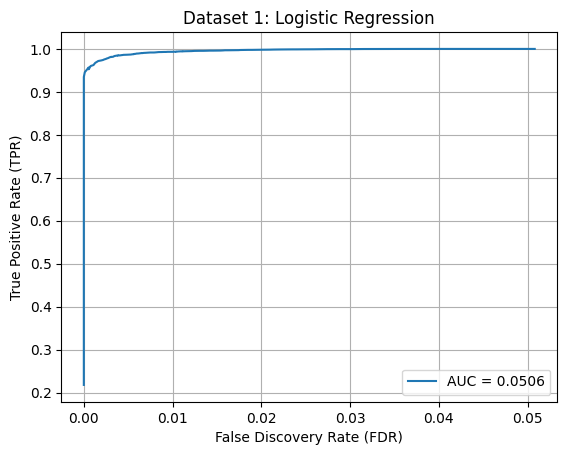

AUC Logistic Regression (Dataset2):  0.04166229523227582


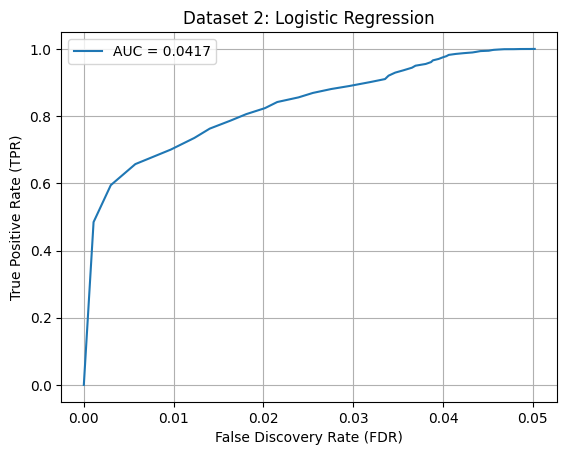

AUC RKHS Regression (SVM) (Dataset1):  0.050561161054898704


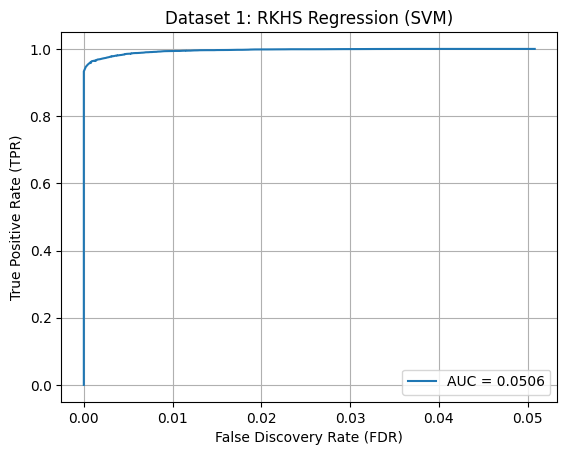

AUC RKHS Regression (SVM) (Dataset2):  0.049018850053240415


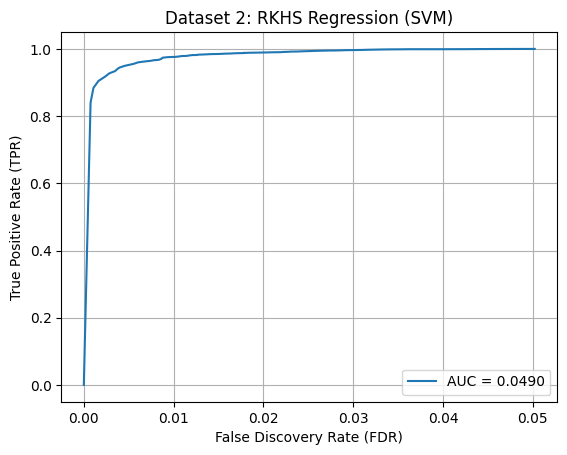

In [115]:
# Exercise 2.c
import matplotlib.pyplot as plt
# To calculate the curves, it is fine to take 100 threshold values c, i.e.,
ths = np.linspace(0, 1, 100)

# To approximately calculate the AUC, it is fine to simply use Riemann sums.
# This means, if you have 100 (a_i, b_i) pairs for the curves, a_1 <= a_2 <= ...
# then you may simply use the sum
# sum_{i=1}^99 (b_i + b_{i+1})/2 * (a_{i+1}-a_i)
# as the approximation of the integral (or AUC)

def calculate_FDR_TPR_AUC(y_true, y_probabilities):
    """
    Calculates FDR/TPR-curve (i.e., FPR vs. TPR curve for different thresholds) and the AUC.
    Note that we have y_probabilities[i] = (P(Y_i=0|X), P(Y_i=1|X))
    """
    assert y_true.shape[0] == y_probabilities.shape[0]
    
    # Calculate positives / negatives (only depending on the dataset)
    positives = np.sum(y_true)

    # Calculate true positives and false positives for all threshold values
    true_positives = []
    false_positives = []
    for th in ths:
        tp = 0
        fp = 0
        for i in range(len(y_probabilities)):
            if y_probabilities[i, 1] >= th:
                if y_true[i] == 1:
                    tp += 1
                else:
                    fp += 1
        true_positives.append(tp)
        false_positives.append(fp)
    
    true_positives = np.array(true_positives, dtype=float)
    false_positives = np.array(false_positives, dtype=float)
    
    # Calculate FDR and TPR rate (points on the FDR/TPR curve) and the AUC
    # FDR = FP/(FP + TP), TPR = TP/P
    # NOTE: We have to handle division by zero cases (else, we get NaNs)
    TPR = np.divide(true_positives, positives, out=np.zeros_like(true_positives), where=positives != 0)
    FDR = np.divide(false_positives, false_positives + true_positives, out=np.zeros_like(false_positives), where=(false_positives + true_positives) != 0)
    
    # Sort FDR and TPR arrays based on FDR, such that we can calculate the AUC (we need monotonically increasing FDR)
    sorted_indices = np.argsort(FDR)
    FDR = FDR[sorted_indices]
    TPR = TPR[sorted_indices]
    
    # We use Riemann sums to approximate the AUC
    # NOTE: Here a lower AUC is better (i.e., we want to minimize FDR (losses) and maximize TPR (business volume))
    AUC = 0
    for i in range(len(FDR) - 1):
        AUC += (TPR[i] + TPR[i+1]) / 2 * (FDR[i+1] - FDR[i])
    
    return FDR, TPR, AUC

def plot_fdr_tpr_curve(FDR, TPR, AUC, title):
    """Plots the FDR/TPR curve"""
    plt.plot(FDR, TPR, label=f"AUC = {AUC:.4f}")
    plt.xlabel('False Discovery Rate (FDR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# first data set & logistic regression:
FDR_lr1, TPR_lr1, AUC_lr1 = calculate_FDR_TPR_AUC(y_test1, pred_test1)
print("AUC Logistic Regression (Dataset1): ", AUC_lr1)
plot_fdr_tpr_curve(FDR_lr1, TPR_lr1, AUC_lr1, "Dataset 1: Logistic Regression")

# second dataset & logistic regression
FDR_lr2, TPR_lr2, AUC_lr2 = calculate_FDR_TPR_AUC(y_test2, pred_test2)
print("AUC Logistic Regression (Dataset2): ", AUC_lr2)
plot_fdr_tpr_curve(FDR_lr2, TPR_lr2, AUC_lr2, "Dataset 2: Logistic Regression")

# first data set and rkhs regression (SVM with RBF kernel):
FDR_svm1, TPR_svm1, AUC_svm1 = calculate_FDR_TPR_AUC(y_test1, pred_test_svm1)
print("AUC RKHS Regression (SVM) (Dataset1): ", AUC_svm1)
plot_fdr_tpr_curve(FDR_svm1, TPR_svm1, AUC_svm1, "Dataset 1: RKHS Regression (SVM)")

# second data set and rkhs regression (SVM with RBF kernel)
FDR_svm2, TPR_svm2, AUC_svm2 = calculate_FDR_TPR_AUC(y_test2, pred_test_svm2)
print("AUC RKHS Regression (SVM) (Dataset2): ", AUC_svm2)
plot_fdr_tpr_curve(FDR_svm2, TPR_svm2, AUC_svm2, "Dataset 2: RKHS Regression (SVM)")

100%|██████████| 10000/10000 [55:21<00:00,  3.01it/s] 


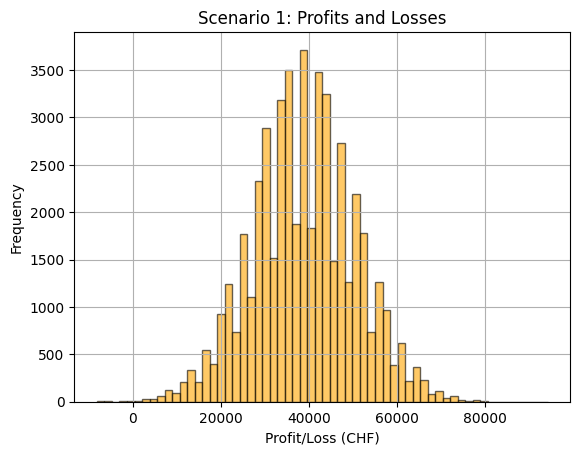

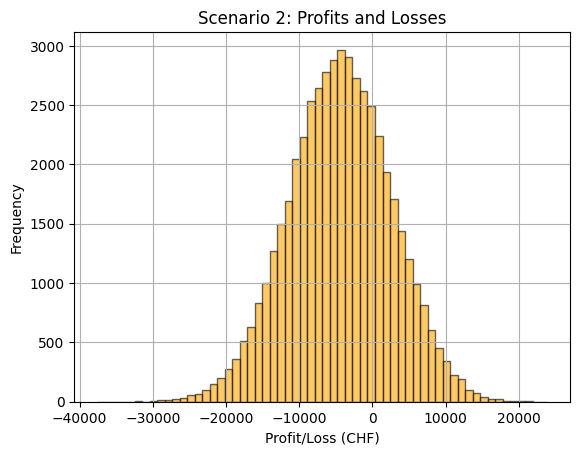

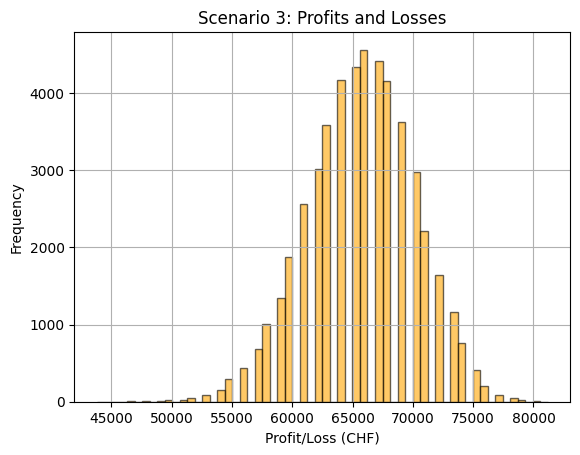

Expected profit/loss (Scenario 1): 38906.3894
95%-VaR (Scenario 1): -20390.0
Expected profit/loss (Scenario 2): -4468.2266
95%-VaR (Scenario 2): 15420.0
Expected profit/loss (Scenario 3): 65692.358
95%-VaR (Scenario 3): -57960.0


In [116]:
# Exercise 3.

# Set model parameters and define matrix D
n = len(y_test2) # Should be 10'000
num_scenarios = 50000  # Number of market scenarios
loan_amount = 1000  # Loan amount (in CHF)
interest_rate_1 = 0.055  # Interest rate for strategy 1
interest_rate_2 = 0.01  # Interest rate for strategy 2 and 3

D = np.zeros((n, num_scenarios))
xi = np.random.uniform(0, 1, (n, num_scenarios))

def plot_histogram(profits, title):
    """Helper function to plot histogram of profits and losses."""
    plt.hist(profits, bins=60, alpha=0.6, color='orange', edgecolor='black')
    plt.title(title)
    plt.xlabel('Profit/Loss (CHF)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    
def calculate_profits_and_var(profits):
    """Helper function to calculate expected profit/loss and 95%-VaR"""
    expected_profit = np.mean(profits)
    var_95 = -np.percentile(profits, 5)
    return expected_profit, var_95


profits_scenario_1 = np.zeros(num_scenarios)
profits_scenario_2 = np.zeros(num_scenarios)
profits_scenario_3 = np.zeros(num_scenarios)

from tqdm import tqdm   # For progress bar

for i in tqdm(range(n)):
    for j in range(num_scenarios):
        #  D[i,k] = 1 means that in scenario k, the i-th loan is paid back with interest. 
        paid_back = xi[i, j] <= p2(X_test2[i])   # D[i,k]=1 if xi[i,k] <= p_2(X[i+m])
        
        # Scenario 1:
        if paid_back:
            profits_scenario_1[j] += loan_amount * interest_rate_1
        else:
            profits_scenario_1[j] -= loan_amount
            
        # Scenario 2:
        if pred_test2[i, 1] >= 0.95: # we gave a loan
            if paid_back:
                profits_scenario_2[j] += loan_amount * interest_rate_2
            else:
                profits_scenario_2[j] -= loan_amount
        
        # Scenario 3:
        if pred_test_svm2[i, 1] >= 0.95: # we gave a loan
            if paid_back:
                profits_scenario_3[j] += loan_amount * interest_rate_2
            else:
                profits_scenario_3[j] -= loan_amount
            

# Plot histogram of profits and losses
plot_histogram(profits_scenario_1, "Scenario 1: Profits and Losses")
plot_histogram(profits_scenario_2, "Scenario 2: Profits and Losses")
plot_histogram(profits_scenario_3, "Scenario 3: Profits and Losses")

# Calculate expected profit/loss and 95%-VaR
expected_profit_1, var_95_1 = calculate_profits_and_var(profits_scenario_1)
print("Expected profit/loss (Scenario 1):", expected_profit_1)
print("95%-VaR (Scenario 1):", var_95_1)
expected_profit_2, var_95_2 = calculate_profits_and_var(profits_scenario_2)
print("Expected profit/loss (Scenario 2):", expected_profit_2)
print("95%-VaR (Scenario 2):", var_95_2)
expected_profit_3, var_95_3 = calculate_profits_and_var(profits_scenario_3)
print("Expected profit/loss (Scenario 3):", expected_profit_3)
print("95%-VaR (Scenario 3):", var_95_3)

### Conclusion
- Highest expected profit is 65'692 CHF, achieved by Strategy 3. However, we also have the highest risk (VaR) here with -57'960 CHF.
- Strategy 1 gives the 2nd best expected profit of 38'906 CHF with a lower risk (VaR) of -20,390 CHF.
- With strategy 2 we have in expectation a loss of 4'468 CHF, so this strategy is not effective.
- **Summary:** While Strategy 3 offers the highest profit, it also comes with the highest risk!